In [1]:
# # Mount the Google drive onto Colab Virtual Environment
# from google.colab import drive
# drive.mount('/content/drive')
root = '.'
# root = '/content/drive/My Drive/English Dataset'

In [2]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import pandas as pd
import pickle

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
filename = os.path.join(root, 'mono.en')

In [4]:
def read_data(filename):
    words = list()
    
    with open(filename) as f:
        c = tf.compat.as_str(f.read(1))
        
        while c:
            word = ''
            
            while c != ' ':
                word += c
                
                c = tf.compat.as_str(f.read(1))
            
            words.append(word)
                
            c = tf.compat.as_str(f.read(1))
            
    return words

words = read_data(filename)
print("Data size %d" % len(words))

Data size 463477


In [5]:
len(set(words))

8730

In [6]:
vocabulary_size = len(set(words)) +1

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Most common words (+UNK)", count[:5])
print("Sample data", data[:10])
del words

Most common words (+UNK) [['UNK', 0], ('the', 22887), ('to', 13574), ('a', 9482), ('you', 8308)]
Sample data [177, 22, 228, 36, 1007, 3618, 1561, 1007, 2534, 1]


In [7]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print("Data:", [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print("\nwith num_skips = %d and skip_window = %d:" % (num_skips, skip_window))
    print("    batch:", [reverse_dictionary[bi] for bi in batch])
    print("    labels:", [reverse_dictionary[di] for di in labels.reshape(8)])

Data: ['give', 'your', 'application', 'an', 'accessibility', 'workout', 'accerciser', 'accessibility']

with num_skips = 2 and skip_window = 1:
    batch: ['your', 'your', 'application', 'application', 'an', 'an', 'accessibility', 'accessibility']
    labels: ['give', 'application', 'an', 'your', 'accessibility', 'application', 'workout', 'an']

with num_skips = 4 and skip_window = 2:
    batch: ['application', 'application', 'application', 'application', 'an', 'an', 'an', 'an']
    labels: ['give', 'your', 'accessibility', 'an', 'accessibility', 'your', 'workout', 'application']


In [8]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                    labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [9]:
num_steps = 100001
loss_list = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset:batch_data, train_labels:batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            
            print("Average loss at step %d: %f" % (step, average_loss))
            loss_list.append(average_loss)
            
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 6.340580
Nearest to go: stuttering, tenthirty, newlibrary…, rang, z, reached, faces, mountainous,
Nearest to no: thursday, goodfornothing, bedrooms, prime, commenting, barbecue, consists, ugly,
Nearest to should: cheers, kilo, debugger, queens, washed, alpha, blamed, variable…,
Nearest to from: heroin, ammunition, buddhist, remind, gently, requires, invitation, grade,
Nearest to with: undefined, forgave, proven, able, parenthese, fastball, price, acceptsave,
Nearest to do: frozen, nap, norway, treaty, creative, sinners, jpg, gym,
Nearest to my: imported, typhoon, distant, steak, software…, entity, disturbed, resulting,
Nearest to if: entertaining, sdlimage, dial, gummy, lays, frame, thats, ask,
Nearest to will: sworn, none, float, well, falls, sysfs, insect, meal,
Nearest to one: merge, wheat, refcount, malformed, mince, indicated, dialed, backrub,
Nearest to be: einstein, sieve, voices, expedited, read, permanently, philosophy, innumerable,
Nearest 

Average loss at step 52000: 1.477781
Average loss at step 54000: 2.339341
Average loss at step 56000: 2.129961
Average loss at step 58000: 1.450757
Average loss at step 60000: 1.861714
Nearest to go: went, going, teach, broccoli, bilinear, sandy, sickness, help,
Nearest to no: teachers, goodfornothing, districts, irresponsible, blondes, gay, authentification, detroit,
Nearest to should: will, can, huh, must, did, won, motioned, wont,
Nearest to from: heroin, gaga, murders, includes, forgave, faucet, garbage, clearall,
Nearest to with: parenthese, recognize, traditionally, churches, goggles, fired, phone, logic,
Nearest to do: buy, understood, matching, eat, did, crybaby, reap, ski,
Nearest to my: your, our, his, toms, marys, the, wheres, bookmarksbarmost,
Nearest to if: smallest, symlink, neighborhood, look, sexual, highly, whitespaces, fried,
Nearest to will: cant, should, must, can, may, ill, wont, to,
Nearest to one: senate, longer, two, colds, refcount, venice, war, somebody,
Neare

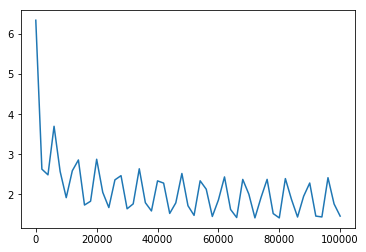

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(range(0, 100001, 2000)), loss_list)
plt.show()

In [11]:
output = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}

In [12]:
with open(os.path.join(root, 'embeddings.en'), 'wb') as f:
    pickle.dump(output, f)